In [1]:
import tensorflow as tf
import numpy as np
import os

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 数据准备

In [2]:
def unpickle(file):
    '''
    CIFAR-10数据读取函数
    '''
    import pickle
    with open(file, 'rb') as fd:
        data = pickle.load(fd, encoding='bytes')
    return data[b'data'], np.array(data[b'labels'])

In [3]:
# 在这里经测试发现MinMaxScaler比StandardScaler效果更好
# 并且plt.imshow()支持[0,1]的输入
from sklearn.preprocessing import MinMaxScaler


class CifarData:
    def __init__(self, paths, batch_size=32, normalize=False, shuffle=False):
        '''
        paths: 文件路径
        '''
        self._data = list()
        self._target = list()
        self._n_samples = 0
        self.n_features = 0

        self._idx = 0    # mini-batch的游标
        self._batch_size = batch_size

        self._load(paths)

        if shuffle:
            self._shuffle_data()
        if normalize:
            self.scaler = MinMaxScaler()    # 缩放器，用于逆缩放恢复原始数据
            self._normalize_data()

        print(self._data.shape, self._target.shape)

    def _load(self, paths):
        '''
        载入数据
        '''
        for path in paths:
            data, labels = unpickle(path)
            self._data.append(data)
            self._target.append(labels)

        # 将所有批次的数据拼接起来
        self._data, self._target = np.vstack(
            self._data), np.hstack(self._target)

        self._n_samples, self.n_features = self._data.shape[0], self._data.shape[1]

    def _shuffle_data(self):
        '''
        打乱数据
        '''
        idxs = np.random.permutation(self._n_samples)
        self._data = self._data[idxs]
        self._target = self._target[idxs]

    def _normalize_data(self):
        self._data = self.scaler.fit_transform(self._data)

    def next_batch(self):
        '''
        生成mini-batch
        '''
        while self._idx < self._n_samples:
            yield self._data[self._idx: (self._idx+self._batch_size)], self._target[self._idx: (self._idx+self._batch_size)]
            self._idx += self._batch_size

        self._idx = 0
        self._shuffle_data()

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
CIFAR_DIR = "../dataset/cifar-10-batches-py/"
train_filenames = [os.path.join(
    CIFAR_DIR, 'data_batch_{}'.format(i)) for i in range(1, 6)]
test_filenames = [os.path.join(CIFAR_DIR, 'test_batch')]

batch_size = 32

# 为了便于后期的可视化
train_data = CifarData(train_filenames, batch_size=batch_size,
                       normalize=True, shuffle=True)
test_data = CifarData(test_filenames, batch_size=batch_size,
                      normalize=True, shuffle=False)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(50000, 3072) (50000,)


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(10000, 3072) (10000,)


# 网络结构设计
AE是一个无监督学习器，网络结构很简单，单层自编码器的结构为：输入层-编码层-解码(输出)层，loss即为输入层与解码层的区别。

In [5]:
unit_I = train_data.n_features    # 输入单元数，等于特征数

unit_h = 512    # 编码尺寸

unit_O = unit_I    # 输出单元数，类别数

# 搭建网络

In [6]:
# 输入必须是可由用户指定的，所以设为placeholder
X = tf.placeholder(tf.float32, [None, unit_I])  # 数据的样本数不指定，只指定特征数
Y = tf.placeholder(tf.int64, [None])    # 目标值为列向量，int64为了兼容

with tf.name_scope('AE'):
    encoder = tf.layers.dense(X, unit_h, activation=tf.nn.relu)
    decoder = tf.layers.dense(encoder, unit_O, activation=None)

# 评估图
with tf.name_scope('Eval'):
    # 计算一维向量与onehot向量之间的损失
    loss = tf.losses.mean_squared_error(labels=X, predictions=decoder)

# 优化图
with tf.name_scope('train_op'):
    lr = 1e-3
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True    # 按需使用显存

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# 训练网络

In [7]:
with tf.Session(config=config) as sess:
    sess.run(init)
    epochs = 5

    batch_cnt = 0
    for epoch in range(epochs):
        for batch_data, batch_labels in train_data.next_batch():
            batch_cnt += 1
            loss_val,  _ = sess.run(
                [loss, train_op],
                feed_dict={
                    X: batch_data,
                    Y: batch_labels})

            # 每1000batch输出一次信息
            if (batch_cnt+1) % 1000 == 0:
                print('epoch: {}, batch_loss: {}'.format(
                    epoch, loss_val))

            # 每5000batch做一次验证
            if (batch_cnt+1) % 5000 == 0:
                all_test_loss_val = list()
                for test_batch_data, test_batch_labels in test_data.next_batch():
                    test_loss_val = sess.run(
                        [loss],
                        feed_dict={
                            X: test_batch_data,
                            Y: test_batch_labels
                        })
                    all_test_loss_val.append(test_loss_val)
                test_loss = np.mean(all_test_loss_val)
                print('epoch: {}, test_loss: {}'.format(epoch, test_loss))

    # 训练完后取出一批测试集做预测，用于可视化
    # 注意这里使用的是测试集
    X_raw = None
    for x, _ in test_data.next_batch():
        X_raw = x
        break
    X_rec = sess.run(decoder, feed_dict={X: X_raw})

epoch: 0, batch_loss: 0.010108386166393757
epoch: 1, batch_loss: 0.008593515492975712
epoch: 1, batch_loss: 0.007346900179982185
epoch: 2, batch_loss: 0.008170894347131252
epoch: 3, batch_loss: 0.00800139456987381
epoch: 3, test_loss: 0.00846326444298029
epoch: 3, batch_loss: 0.008797270245850086
epoch: 4, batch_loss: 0.010427377186715603


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

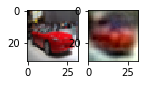

In [35]:
import matplotlib.pyplot as plt
import random

val_idx = random.randrange(len(X_raw))    # 随机选出一张用于可视化的图片


plt.clf()
fig, axs = plt.subplots(1, 2, figsize=(2, 1))
axs[0].imshow(X_raw[val_idx].reshape((3, 32, 32)).transpose((1, 2, 0)))
axs[1].imshow(X_rec[val_idx].reshape((3, 32, 32)).transpose((1, 2, 0)))
plt.show()

最后还是想提一句的是，这里可视化用的是测试集中的图片，一般网上实现AE使用的都是训练集的图片。当然，使用训练集图片可以查看AE模型的压缩效果，因为AE本来就是用于压缩数据。当使用测试集图片时，体现的是AE模型在像素级别上的推理能力。

对于多层AE模型，简单的堆叠全连接层即可，不过注意，encoder层的单元数是越来越少的，而decoder层的单元数是越来越多的。